In [1]:
import datetime
import json
import os
import sys
import pathlib
from collections import defaultdict
import transformers
from tqdm import tqdm_notebook
from transformers import pipeline
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
from matplotlib import pyplot as plt
import plotly.express as px
from binance.client import Client

In [2]:
sentiment_analyzer = pipeline('sentiment-analysis')

In [3]:
sentiment_analyzer('I like my cat')

[{'label': 'POSITIVE', 'score': 0.9997277855873108}]

In [4]:
PROJECT_ROOT = pathlib.Path.cwd().parent
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

from project_settings import BINANCE_KEY, BINANCE_SECRET

In [5]:
name_mapping = {"Cardano": "ADAUSDT", "Ripple": "XRPUSDT"}
symbol = "XRPUSDT"

In [6]:
client = Client(BINANCE_KEY, BINANCE_SECRET)
klines = client.get_historical_klines(symbol, Client.KLINE_INTERVAL_1DAY, "1 Jan, 2015")
print("History size:", len(klines))

History size: 1159


In [7]:
price = []
time = []
volume = []
for c in klines:
    time.append(datetime.datetime.fromtimestamp(int(str(c[0])[:-3])))
    price.append(float(c[4]))
    volume.append(float(c[5]))

hist_prices = pd.DataFrame({"time": time, "price": price, 'volume': volume})
hist_prices.head()

,time,price,volume
0,2018-05-04 03:00:00,0.88990,20890213.82
1,2018-05-05 03:00:00,0.90280,16816165.30
2,2018-05-06 03:00:00,0.86483,16002035.80
3,2018-05-07 03:00:00,0.82490,17303486.40
4,2018-05-08 03:00:00,0.80667,12971303.18


<AxesSubplot:xlabel='time', ylabel='price'>

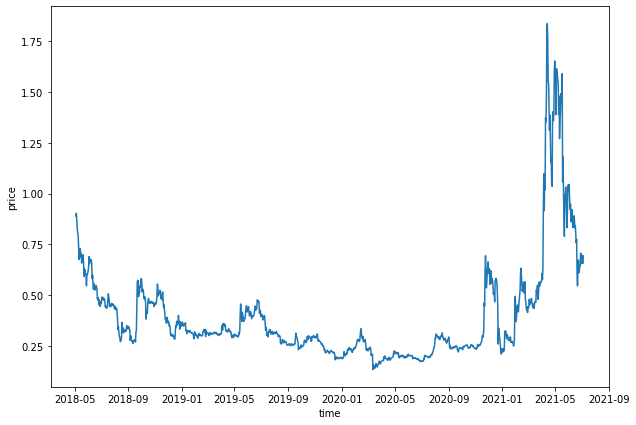

In [8]:
plt.figure(figsize=(10, 7))
sns.lineplot(x=hist_prices["time"], y=hist_prices["price"])


In [9]:
def make_report():
    dfs = []
    base_path = PROJECT_ROOT / "reddit_scraper" / "data"
    for file_name in tqdm_notebook(list(os.walk(base_path))[0][2]):
        file_path = str(base_path / f"{file_name}")
        with open(file_path, "r") as f:
            raw_data = json.load(f)
            data = []

            for item in raw_data:
                if type(item) == list:
                    data.extend(item)
                else:
                    data.append(item)

        result = defaultdict(lambda: defaultdict(int))
        sentiment_result = defaultdict(lambda: defaultdict(list))

        for i in data:
            keyword = i["keyword"]
            comments = i["num_comments"]
            if i["type"] == "posts":
                result[keyword]["num_keyword_posts"] += 1
                result[keyword]["num_comments"] += comments
            elif i["type"] == "comments":
                result[keyword]["num_keyword_comments"] += 1
            if i["text"] is not None and len(i["text"]) > 0 and len(i["text"]) < 500:
                sentiment = sentiment_analyzer(i["text"])[0]
                sen_label = sentiment["label"]
                sen_score = sentiment["score"]
                if sen_label == "POSITIVE":
                    sentiment_result[keyword]["pos_sentiment"].append(sen_score)
                elif sen_label == "NEGATIVE":
                    sentiment_result[keyword]["neg_sentiment"].append(sen_score)
                else:
                    raise

        for keyword in sentiment_result.keys():
            for sentiment_type in sentiment_result[keyword]:
                scores = sentiment_result[keyword][sentiment_type]
                mean_score = np.mean(scores)/len(scores)
                result[keyword][sentiment_type] = mean_score

        df = pd.DataFrame(result).T
        df["date"] = file_path.split("_")[-1].split(".")[0]
        dfs.append(df)

    stat_df = pd.concat(dfs).reset_index().rename(columns={"index": "keyword"}).sort_values(["keyword", "date"])
    stat_df = stat_df[["date", "keyword", "num_keyword_posts", "num_comments", "num_keyword_comments", "pos_sentiment",
                       "neg_sentiment"]]
    stat_df.to_csv(PROJECT_ROOT / "reddit_scraper" / "reddit_crypto_stat.csv", index=False)

In [10]:
make_report()

/tmp/ipykernel_90905/446172504.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for file_name in tqdm_notebook(list(os.walk(base_path))[0][2]):


  0%|          | 0/52 [00:00<?, ?it/s]

In [11]:
def min_max_scale(col):
    return (col - col.min()) / (col.max() - col.min())


def fetch_reddit_data(symbol: str):
    history_data_path = PROJECT_ROOT / "reddit_scraper" / 'reddit_crypto_stat.csv'
    df = pd.read_csv(history_data_path)
    df["keyword"] = df["keyword"].map(name_mapping)
    df = df.set_index(['keyword', 'date'])
    df = df.sort_index()
    df.head()
    sub_df = df.loc[symbol]
    sub_df = pd.DataFrame(data=sub_df.apply(lambda x: min_max_scale(x), axis=0), index=sub_df.index,
                          columns=sub_df.columns)
    sub_df.index = pd.to_datetime(sub_df.index, yearfirst=True)

    return sub_df

In [12]:
hist_reddit = fetch_reddit_data(symbol)
hist_prices_new = hist_prices.set_index("time").loc[hist_reddit.index[0]:]

In [13]:
hist_reddit.head()

,num_keyword_posts,num_comments,num_keyword_comments,pos_sentiment,neg_sentiment
date,,,,,
2021-05-15,0.491228,0.336542,0.390476,0.000000,0.115792
2021-05-16,0.407895,0.280267,0.295238,0.124611,0.235696
2021-05-17,0.179825,0.295446,0.161905,0.251888,0.181381
2021-05-18,0.460526,0.322103,0.400000,0.426026,0.076326
2021-05-19,0.609649,0.798223,0.676190,0.435856,0.101278


In [15]:
fig = px.line(x=hist_reddit.index, y=hist_reddit.num_comments.rolling(5, min_periods=1).mean(), title=symbol)
fig.add_scatter(x=hist_reddit.index, y=hist_reddit.num_comments.rolling(5, min_periods=1).mean(), name='Comments')
fig.add_scatter(x=hist_reddit.index, y=hist_reddit.num_keyword_posts.rolling(5, min_periods=1).mean(),
                name='Keyword posts')
fig.add_scatter(x=hist_reddit.index, y=hist_reddit.num_keyword_comments.rolling(5, min_periods=1).mean(),
                name='Keyword comments')
fig.add_scatter(x=hist_reddit.index, y=hist_reddit.neg_sentiment.rolling(5, min_periods=1).mean(),
                name='Neg sentiment')
fig.add_scatter(x=hist_reddit.index, y=hist_reddit.pos_sentiment.rolling(5, min_periods=1).mean(),
                name='Pos sentiment')
fig.add_scatter(x=hist_prices_new.index, y=hist_prices_new.price, name='Price')
fig.show()